In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.config import TRACKING_PATH
from src.utils.eye_tracking_data import get_gaze_data, with_time_since_start_column
from src.utils.file import get_files_recursive, get_sequence_id_from_file_path

N_NSEC_IN_SEC = 1e9

In [101]:
gaze_data = get_gaze_data(
    experiment_ids=[1],
    sequence_ids=[1],
    set_ids=[0],
    fixation=True,
)
gaze_data = with_time_since_start_column(gaze_data)
gaze_data["TimeSinceStart_s"] = gaze_data["TimeSinceStart_ns"] // N_NSEC_IN_SEC
gaze_data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,SetId,X_sc,Y_sc,X_px,Y_px,StartTimestamp_ns,EndTimestamp_ns,Duration_ns,TimeSinceStart_ns,TimeSinceStart_s
3521,1,1,5,1,0,0.465146,0.680580,2857.8582,2090.7420,8492823774500000000,8492823774800000000,300000000,0,0.0
3522,1,1,5,1,0,0.503090,0.711081,3090.9863,2184.4404,8492823774800000000,8492823775100000000,300000000,300000000,0.0
3523,1,1,5,1,0,0.443968,0.837681,2727.7390,2573.3567,8492823776300000000,8492823776600000000,300000000,1800000000,1.0
3524,1,1,5,1,0,0.691043,0.908784,4245.7670,2791.7837,8492823777000000000,8492823777250000000,250000000,2500000000,2.0
3525,1,1,5,1,0,0.585846,0.904174,3599.4407,2777.6223,8492823777250000000,8492823777500000000,250000000,2750000000,2.0


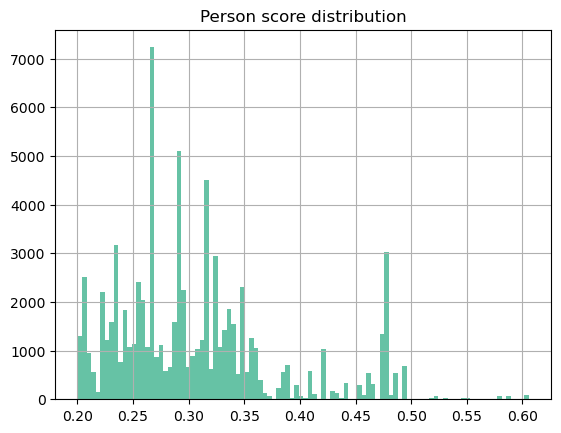

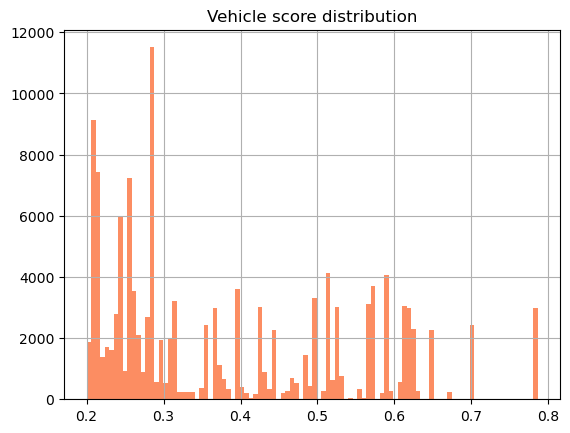

,InstanceId,Score,LabelId,LabelStr,BoundingBox_px,BoundingBox_sc,CenterX_px,CenterY_px,CenterX_sc,CenterY_sc,FrameId,TimeSinceStart_ns,SequenceId,LabelClass,DistanceFromLast_px,AngleOfMovement_deg,TimeSinceStart_s
0,0,0.569452,3,car,[1254.2964 671.4483 1354.7358 721.31683],[0.523496 0.78075385 0.5654156 0.8387405 ],1304.516113,696.382568,0.544456,0.809747,0,0.0,1,vehicle,NaN,NaN,0.0
10,0,0.569452,3,car,[1254.2739 671.43616 1354.7435 721.32635],[0.5234866 0.7807397 0.56541884 0.83875155],1304.508789,696.381226,0.544453,0.809746,1,40000000.0,1,vehicle,0.007446,-169.611142,0.0
20,0,0.569452,3,car,[1254.2251 671.3938 1354.758 721.3041],[0.5234662 0.7806905 0.5654249 0.8387257],1304.491577,696.348938,0.544446,0.809708,2,80000000.0,1,vehicle,0.036589,-118.061243,0.0
30,0,0.569452,3,car,[1254.1747 671.3484 1354.7797 721.2967],[0.5234452 0.7806377 0.5654339 0.8387171],1304.477173,696.322510,0.544440,0.809677,3,120000000.0,1,vehicle,0.030099,-118.591914,0.0
41,0,0.569452,3,car,[1254.1193 671.28125 1354.8165 721.2685 ],[0.52342206 0.7805596 0.5654493 0.8386843 ],1304.467896,696.274902,0.544436,0.809622,4,160000000.0,1,vehicle,0.048503,-101.027132,0.0


In [123]:
def get_object_data(
        person_score_threshold: float = 0.2,
        vehicle_score_threshold: float = 0.3,
):
    all_tracking_data = []
    file_paths = get_files_recursive(TRACKING_PATH, "scene*.csv")
    for file_path in file_paths:
        sequence_id = get_sequence_id_from_file_path(file_path)
        tracking_data = pd.read_csv(file_path)
        tracking_data["SequenceId"] = sequence_id
        all_tracking_data.append(tracking_data)

    all_tracking_data = pd.concat(all_tracking_data)

    # Merge vehicle classes
    all_tracking_data["LabelClass"] = all_tracking_data["LabelStr"].replace(
        {
            "truck": "vehicle",
            "bus": "vehicle",
            "car": "vehicle",
            "motorcycle": "vehicle",
            "bike": "vehicle",
        }
    )

    colors = sns.color_palette("Set2", n_colors=2)
    all_tracking_data[all_tracking_data["LabelClass"] == "person"]["Score"].hist(bins=100, color=colors[0])
    plt.title("Person score distribution")
    plt.show()
    all_tracking_data[all_tracking_data["LabelClass"] == "vehicle"]["Score"].hist(bins=100, color=colors[1])
    plt.title("Vehicle score distribution")
    plt.show()

    # Filter out objects with low scores
    all_tracking_data = all_tracking_data[
        ((all_tracking_data["LabelClass"] == "person")
        & (all_tracking_data["Score"] > person_score_threshold))
        | ((all_tracking_data["LabelClass"] == "vehicle")
        & (all_tracking_data["Score"] > vehicle_score_threshold))
    ]

    # Add distance from last frame and angle of movement
    all_tracking_data = all_tracking_data.sort_values(["SequenceId", "InstanceId", "FrameId"])
    all_tracking_data["CenterXDiff_px"] = all_tracking_data.groupby(["SequenceId", "InstanceId"])["CenterX_px"].diff()
    all_tracking_data["CenterYDiff_px"] = all_tracking_data.groupby(["SequenceId", "InstanceId"])["CenterY_px"].diff()
    all_tracking_data["DistanceFromLast_px"] = np.sqrt(all_tracking_data["CenterXDiff_px"]**2 + all_tracking_data["CenterYDiff_px"]**2)
    all_tracking_data["AngleOfMovement_deg"] = np.arctan2(all_tracking_data["CenterYDiff_px"], all_tracking_data["CenterXDiff_px"]).apply(np.degrees)
    all_tracking_data = all_tracking_data.drop(columns=["CenterXDiff_px", "CenterYDiff_px"])

    all_tracking_data["TimeSinceStart_s"] = all_tracking_data["TimeSinceStart_ns"] // N_NSEC_IN_SEC

    return all_tracking_data

object_data = get_object_data()
object_data.head()

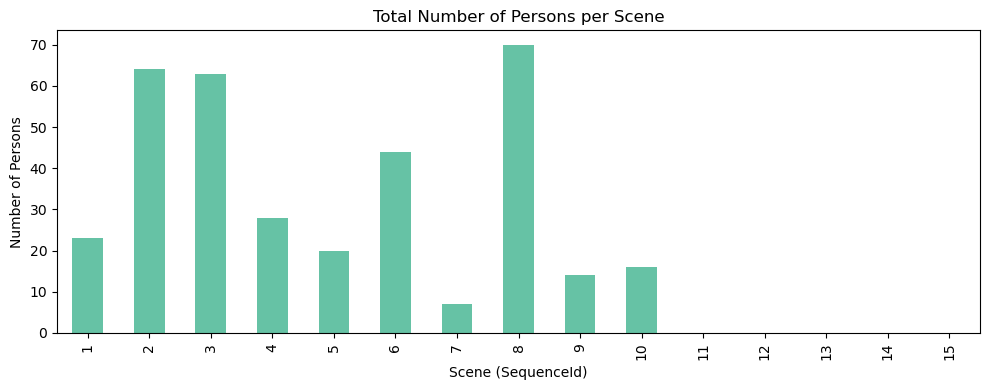

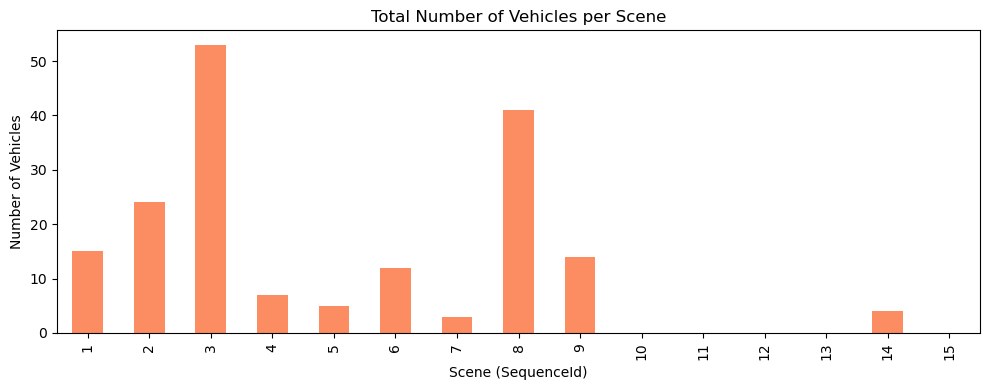

In [71]:
def plot_object_counts(object_data, object_types):
    object_data = object_data.copy()
    
    all_scenes = range(1, 16)
    colors = sns.color_palette('Set2', n_colors=len(object_types))
    for obj_type in object_types:
        # Filter data for the specific object type
        filtered_data = object_data[object_data["LabelClass"] == obj_type]

        # Get unique instances
        filtered_data = filtered_data.drop_duplicates(subset=['SequenceId', 'InstanceId'])
        
        # Group by 'SequenceId' and count occurrences for each scene
        object_counts = filtered_data.groupby('SequenceId').size()

         # Reindex to include all scenes, filling missing scenes with 0
        object_counts = object_counts.reindex(all_scenes, fill_value=0)
        
        # Create the bar plot
        plt.figure(figsize=(10, 4))
        object_counts.plot(kind='bar', color=colors[object_types.index(obj_type)])
        plt.title(f'Total Number of {obj_type.capitalize()}s per Scene')
        plt.xlabel('Scene (SequenceId)')
        plt.ylabel(f'Number of {obj_type.capitalize()}s')
        plt.tight_layout()
        plt.show()

plot_object_counts(object_data, ['person', 'vehicle'])

In [79]:
def plot_object_motion(object_data, object_types):
    object_data = object_data.copy()

    all_scenes = range(1, 16)
    colors = sns.color_palette('Set2', n_colors=len(object_types))

    for obj_type in object_types:
        motion_data = object_data[object_data["LabelClass"] == obj_type]
        print(len(motion_data))
        motion_data = motion_data.groupby(['SequenceId', 'InstanceId'])['DistanceFromLast_px'].sum().reset_index()
        motion_data = motion_data.groupby('SequenceId')['DistanceFromLast_px'].sum()
        motion_data = motion_data.reindex(all_scenes, fill_value=0)

        # Create the bar plot
        plt.figure(figsize=(10, 4))
        motion_data.plot(kind='bar', color=colors[object_types.index(obj_type)])
        plt.title(f'Total Number of Moving {obj_type.capitalize()}s per Scene')
        plt.xlabel('Scene (SequenceId)')
        plt.ylabel(f'Number of Moving {obj_type.capitalize()}s')
        plt.tight_layout()
        plt.show()

79089


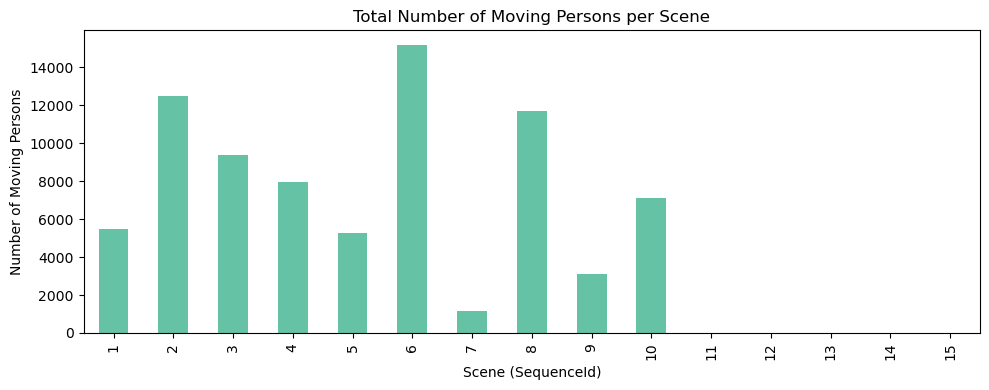

70299


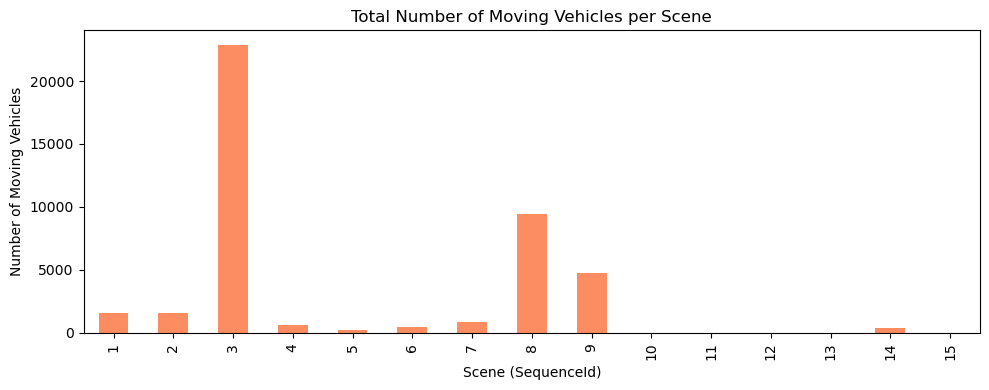

In [80]:
plot_object_motion(object_data, ['person', 'vehicle'])

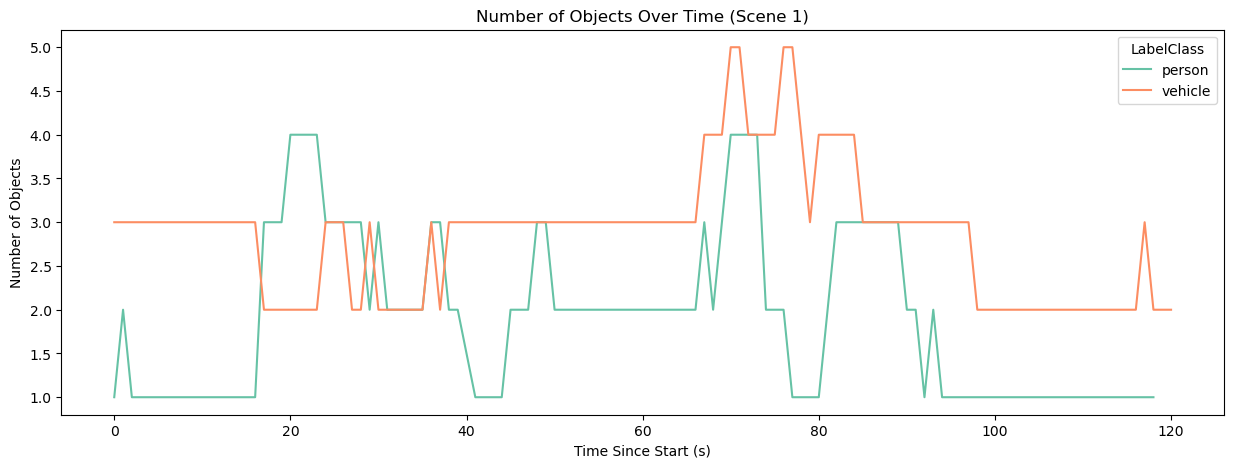

In [90]:
def plot_objects_over_time(
    data: pd.DataFrame,
    sequence_id: int,
):
    data = data.copy()
    data = data[data["SequenceId"] == sequence_id]
    data = data[~data["LabelClass"].str.contains("building")]
    unique_data = data[["InstanceId", "LabelClass", "TimeSinceStart_s"]].copy().drop_duplicates(subset=["InstanceId", "TimeSinceStart_s"])
    unique_data = unique_data.groupby(["TimeSinceStart_s", "LabelClass"]).size().reset_index(name="Count")

    # Plot
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette("Set2", n_colors=len(unique_data["LabelClass"].unique()))
    sns.lineplot(data=unique_data, x="TimeSinceStart_s", y="Count", hue="LabelClass", palette=colors)
    plt.title(f"Number of Objects Over Time (Scene {sequence_id})")
    plt.xlabel("Time Since Start (s)")
    plt.ylabel("Number of Objects")
    plt.show()

plot_objects_over_time(data=object_data, sequence_id=1)

In [96]:
def plot_object_fixations(gaze_data, object_data):
    gaze_data = gaze_data.copy()
    gaze_data = gaze_data[gaze_data["ExperimentId"] == 1 & gaze_data["SetId"] == 0]
    gaze_data = gaze_data[["SequenceId", "TimeSinceStart_s", "X_px", "Y_px"]]
    
    object_data = object_data.copy()
    object_data = object_data[~object_data["LabelClass"].str.contains("building")]
    object_data = object_data[["SequenceId", "InstanceId", "TimeSinceStart_s", "CenterX_px", "CenterY_px"]]

    # Merge gaze data with object data
    merged_data = pd.merge_asof(
        gaze_data.sort_values("TimeSinceStart_s"),
        object_data.sort_values("TimeSinceStart_s"),
        by="SequenceId",
        on="TimeSinceStart_s",
        direction="forward",
        tolerance=1,
    )

In [121]:
test_object_data = pd.DataFrame({
    "SequenceId": [1, 1, 1, 1, 1],
    "InstanceId": [0, 0, 0, 1, 1],
    "Score": [1.0, 1.0, 1.0, 1.0, 1.0],
    "LabelId": [0, 0, 0, 1, 1],
    "LabelStr": ["car", "car", "car", "person", "person"],
    "LabelClass": ["vehicle", "vehicle", "vehicle", "person", "person"],
    "BoundingBox_px": [
        [0.0, 0.0, 100.0, 100.0],
        [10.0, 10.0, 110.0, 110.0],
        [20.0, 20.0, 120.0, 120.0],
        [100.0, 100.0, 200.0, 200.0],
        [90.0, 90.0, 190.0, 190.0],
    ],
    "BoundingBox_sc": [
        [0.0, 0.0, 0.5, 0.5],
        [0.05, 0.05, 0.55, 0.55],
        [0.1, 0.1, 0.6, 0.6],
        [0.5, 0.5, 1.0, 1.0],
        [0.45, 0.45, 0.95, 0.95],
    ],
    "CenterX_px": [50.0, 60.0, 70.0, 150.0, 140.0],
    "CenterY_px": [50.0, 60.0, 70.0, 150.0, 140.0],
    "CenterX_sc": [0.25, 0.3, 0.35, 0.75, 0.7],
    "CenterY_sc": [0.25, 0.3, 0.35, 0.75, 0.7],
    "FrameId": [0, 1, 2, 0, 1],
    "TimeSinceStart_ns": [0, 1e9, 2e9, 0, 1e9],
    "DistanceFromLast_px": [pd.NA, 14.142136, 14.142136, pd.NA, 14.142136],
    "AngleOfMovement_deg": [pd.NA, 45.0, 45.0, pd.NA, -45.0],
})
test_object_data.head()

,SequenceId,InstanceId,Score,LabelId,LabelStr,LabelClass,BoundingBox_px,BoundingBox_sc,CenterX_px,CenterY_px,CenterX_sc,CenterY_sc,FrameId,TimeSinceStart_ns,DistanceFromLast_px,AngleOfMovement_deg
0,1,0,1.0,0,car,vehicle,"[0.0, 0.0, 100.0, 100.0]","[0.0, 0.0, 0.5, 0.5]",50.0,50.0,0.25,0.25,0,0.000000e+00,<NA>,<NA>
1,1,0,1.0,0,car,vehicle,"[10.0, 10.0, 110.0, 110.0]","[0.05, 0.05, 0.55, 0.55]",60.0,60.0,0.30,0.30,1,1.000000e+09,14.142136,45.0
2,1,0,1.0,0,car,vehicle,"[20.0, 20.0, 120.0, 120.0]","[0.1, 0.1, 0.6, 0.6]",70.0,70.0,0.35,0.35,2,2.000000e+09,14.142136,45.0
3,1,1,1.0,1,person,person,"[100.0, 100.0, 200.0, 200.0]","[0.5, 0.5, 1.0, 1.0]",150.0,150.0,0.75,0.75,0,0.000000e+00,<NA>,<NA>
4,1,1,1.0,1,person,person,"[90.0, 90.0, 190.0, 190.0]","[0.45, 0.45, 0.95, 0.95]",140.0,140.0,0.70,0.70,1,1.000000e+09,14.142136,-45.0


In [122]:
test_gaze_data = pd.DataFrame({
    "ExperimentId": [1, 1, 1, 1, 1],
    "SessionId": [0, 0, 0, 0, 0],
    "ParticipantId": [1, 1, 1, 1, 1],
    "SequenceId": [1, 1, 1, 1, 1],
    "SetId": [0, 0, 0, 0, 0],
    "X_px": [40.0, 65.0, 150.0, 145.0],
    "Y_px": [40.0, 65.0, 150.0, 130.0],
    "X_sc": [0.2, 0.325, 0.75, 0.725],
    "Y_sc": [0.2, 0.325, 0.75, 0.65],
    "StartTimeStamp_ns": [0, 1e9, 2e9, 3e9],
    "EndTimeStamp_ns": [1e9, 2e9, 3e9, 4e9],
    "Duration_ns": [1e9, 1e9, 1e9, 1e9],
    "TimeSinceStart_ns": [0, 1e9, 2e9, 3e9],
    "TimeSinceStart_s": [0, 1, 2, 3],
})
test_gaze_data.head()

ValueError: All arrays must be of the same length

In [ ]:
plot_object_fixations(gaze_data=test_gaze_data, object_data=test_object_data)

In [97]:
plot_object_fixations(gaze_data=gaze_data, object_data=object_data)

   SequenceId  InstanceId  TimeSinceStart_s  DistanceFromLast_px
0           1           0               0.0             0.026501
1           1           0               1.0             0.022845
2           1           0               2.0             0.021924
3           1           0               3.0             0.014051
4           1           0               4.0             0.018637
